In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [7]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [8]:
def compute_SMA(series, window=7):
    return series.rolling(window=window).mean()

def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

def compute_stochastic_oscillator(high, low, close, window=14):
    lowest_low = low.rolling(window=window).min()
    highest_high = high.rolling(window=window).max()
    stoch = 100 * (close - lowest_low) / (highest_high - lowest_low)
    return stoch

In [9]:
train_path = "AUD_USD_Historical_Data_TRAIN.csv"
test_path  = "AUD_USD_Historical_Data_TEST.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Convert Date column to datetime (format is DD/MM/YYYY)
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%d/%m/%Y')
test_df['Date']  = pd.to_datetime(test_df['Date'], format='%d/%m/%Y')

# Sort by date to ensure proper time ordering
train_df.sort_values('Date', inplace=True)
test_df.sort_values('Date', inplace=True)

# Remove the '%' sign from "Change %" and convert to float
for df in [train_df, test_df]:
    df['Change %'] = df['Change %'].str.rstrip('%').astype(float)

# Compute technical indicators on each dataset
for df in [train_df, test_df]:
    df['SMA'] = compute_SMA(df['Open'], window=7)
    df['RSI'] = compute_RSI(df['Open'], window=14)
    df['Stoch'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Open'], window=14)

# Drop rows with NaN values that result from indicator calculations
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Define features and target.
# The target is "Open" while all other columns (except Date) are used as features.
feature_cols = ['Price', 'Open', 'High', 'Low', 'Change %', 'SMA', 'RSI', 'Stoch']
target_col = ['Open']

In [10]:
# Prepare features and target
train_features = train_df[feature_cols]
train_target   = train_df[target_col]
test_features  = test_df[feature_cols]
test_target    = test_df[target_col]

# Use StandardScaler separately for features and target (fit on train only)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

scaler_X.fit(train_features)
train_features_scaled = scaler_X.transform(train_features)
test_features_scaled  = scaler_X.transform(test_features)

scaler_y.fit(train_target)
train_target_scaled = scaler_y.transform(train_target)
test_target_scaled  = scaler_y.transform(test_target)

# Create sequences: use the past 30 days to predict the next day's open price
def create_sequences(features, target, seq_length=30):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]  # forecast the open price at time i+seq_length
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X_train, y_train = create_sequences(train_features_scaled, train_target_scaled, seq_length)
X_test, y_test   = create_sequences(test_features_scaled, test_target_scaled, seq_length)

# Create PyTorch datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset  = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                              torch.tensor(y_test, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class CNN_RNN(nn.Module):
    def __init__(self, rnn_type='LSTM', num_features=8, cnn_channels=64, kernel_size=3, rnn_hidden=50, num_layers=1):
        super(CNN_RNN, self).__init__()
        # Conv1d expects (batch, channels, sequence_length); channels = number of features.
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=cnn_channels, 
                               kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        # RNN layer (LSTM or GRU). Input size equals cnn_channels.
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=cnn_channels, hidden_size=rnn_hidden, 
                               num_layers=num_layers, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=cnn_channels, hidden_size=rnn_hidden, 
                              num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Unsupported rnn_type. Use 'LSTM' or 'GRU'")
        # Final fully connected layer outputs a single value (forecast open price)
        self.fc = nn.Linear(rnn_hidden, 1)
    
    def forward(self, x):
        # x: (batch, seq_length, num_features)
        # Rearrange for convolution: (batch, num_features, seq_length)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        # Rearrange back for RNN: (batch, seq_length, cnn_channels)
        x = x.permute(0, 2, 1)
        # Pass through RNN (returns output for each time step)
        rnn_out, _ = self.rnn(x)
        # Use the output at the last time step
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        return out


In [12]:
num_features = len(feature_cols)
model_lstm = CNN_RNN(rnn_type='LSTM', num_features=num_features).to(device)
model_gru  = CNN_RNN(rnn_type='GRU',  num_features=num_features).to(device)


In [13]:
def train_model(model, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")


In [14]:
print("Training CNN-LSTM model")
train_model(model_lstm, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss())

print("\nTraining CNN-GRU model")
train_model(model_gru, train_loader, num_epochs=50, lr=1e-3, criterion=nn.MSELoss())


Training CNN-LSTM model
Epoch 5/50, Loss: 0.0003
Epoch 10/50, Loss: 0.0002
Epoch 15/50, Loss: 0.0001
Epoch 20/50, Loss: 0.0001
Epoch 25/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0001
Epoch 35/50, Loss: 0.0001
Epoch 40/50, Loss: 0.0001
Epoch 45/50, Loss: 0.0001
Epoch 50/50, Loss: 0.0001

Training CNN-GRU model
Epoch 5/50, Loss: 0.0006
Epoch 10/50, Loss: 0.0003
Epoch 15/50, Loss: 0.0002
Epoch 20/50, Loss: 0.0002
Epoch 25/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0001
Epoch 35/50, Loss: 0.0001
Epoch 40/50, Loss: 0.0001
Epoch 45/50, Loss: 0.0001
Epoch 50/50, Loss: 0.0001


In [15]:
def evaluate_model(model, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            predictions.append(outputs.cpu().numpy())
            actuals.append(batch_y.numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return predictions, actuals

# Get predictions for each model on the test set
preds_lstm, actuals = evaluate_model(model_lstm, test_loader)
preds_gru, _       = evaluate_model(model_gru, test_loader)

# Inverse transform predictions and actuals to original scale
preds_lstm_inv = scaler_y.inverse_transform(preds_lstm)
preds_gru_inv  = scaler_y.inverse_transform(preds_gru)
actuals_inv    = scaler_y.inverse_transform(actuals)


In [16]:
mae_lstm = mean_absolute_error(actuals_inv, preds_lstm_inv)
mse_lstm = mean_squared_error(actuals_inv, preds_lstm_inv)
mae_gru  = mean_absolute_error(actuals_inv, preds_gru_inv)
mse_gru  = mean_squared_error(actuals_inv, preds_gru_inv)

print("\nCNN-LSTM Performance: MAE = {:.4f}, MSE = {:.4f}".format(mae_lstm, mse_lstm))
print("CNN-GRU Performance:  MAE = {:.4f}, MSE = {:.4f}".format(mae_gru, mse_gru))



CNN-LSTM Performance: MAE = 0.0011, MSE = 0.0000
CNN-GRU Performance:  MAE = 0.0009, MSE = 0.0000


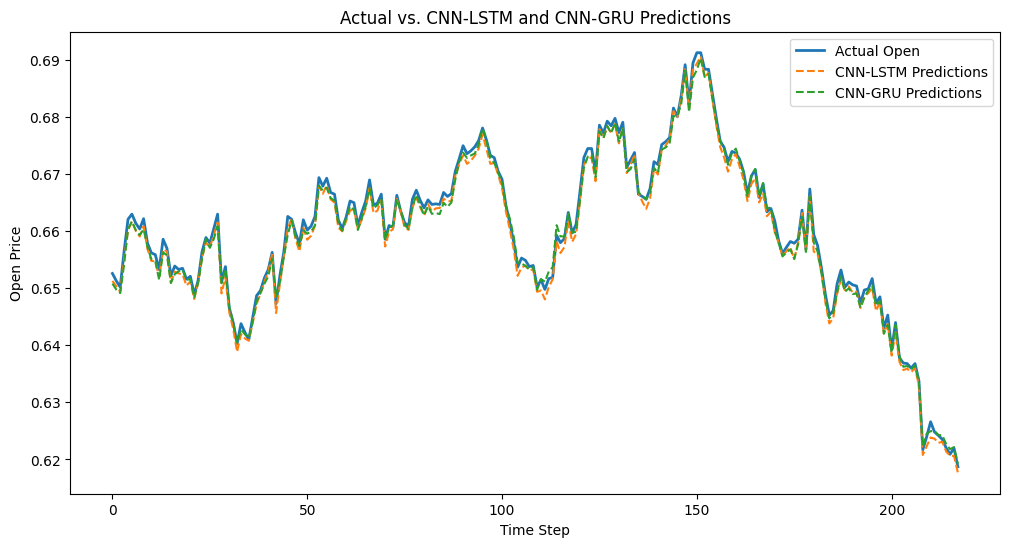

In [17]:
plt.figure(figsize=(12,6))
plt.plot(actuals_inv, label='Actual Open', linewidth=2)
plt.plot(preds_lstm_inv, label='CNN-LSTM Predictions', linestyle='--')
plt.plot(preds_gru_inv, label='CNN-GRU Predictions', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Open Price')
plt.title('Actual vs. CNN-LSTM and CNN-GRU Predictions')
plt.legend()
plt.show()